# Day 2: Advanced Data Cleaning & Machine Learning

**Dataset**: Titanic Passenger Data (891 passengers)

---

### Learning Objectives
By the end of this notebook, you will be able to:
1.  Perform **Exploratory Data Analysis (EDA)** to understand data quality issues.
2.  **Diagnose** the type of missing data: **MCAR**, **MAR**, or **MNAR**.
3.  Choose the **right imputation strategy** based on the diagnosis.
4.  Compare three **Imputation Strategies** (Simple, KNN, MICE) and understand when to use each.
5.  Explain why **Feature Scaling** matters for distance-based and regularized models.
6.  Evaluate models using **Precision, Recall, F1-Score**, and **Confusion Matrix**.

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Imputation
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

## 1. Loading the Data
We load the Titanic dataset directly from GitHub. Each row represents one passenger.

In [27]:
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df_raw = pd.read_csv(url)
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Exploratory Data Analysis (EDA)
Before we clean or model anything, we need to **understand** the data.
We are looking for:
-   What data types do we have? (Numbers vs Text)
-   How much data is missing, and where?
-   What do the distributions look like?
-   Are there obvious patterns related to survival?

### 2.1 Shape & Structure
`df.shape` tells us the number of rows and columns. `df.info()` shows us the data type of each column and how many non-null values it has.

In [28]:
print(f"Dataset Shape: {df_raw.shape[0]} rows x {df_raw.shape[1]} columns")
print()
df_raw.info()

Dataset Shape: 891 rows x 12 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 2.2 Missing Values Count
Let's see exactly how many values are missing per column. This tells us which columns need imputation.

In [29]:
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw) * 100).round(1)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)

,Missing Count,Missing %
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


### 2.3 Missing Data Heatmap
A visual map of where the missing data lives. Yellow = Missing, Purple = Present.

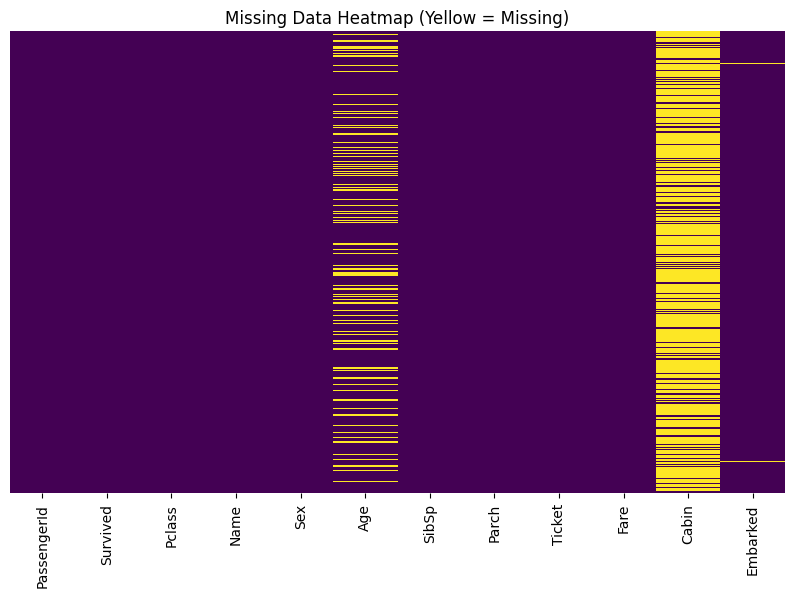

In [30]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_raw.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Heatmap (Yellow = Missing)')
plt.show()

### 2.4 Statistical Summary
`df.describe()` gives us min, max, mean, and standard deviation.

**Key Observation**: Look at the **range** of each feature:
-   **Age**: 0.42 to 80 (range ~ 80)
-   **Fare**: 0 to 512 (range ~ 512)

This means **Fare is ~6x larger than Age**. Distance-based algorithms like KNN will be dominated by Fare unless we **scale** the features.

In [31]:
df_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 2.5 Distribution & Survival Patterns

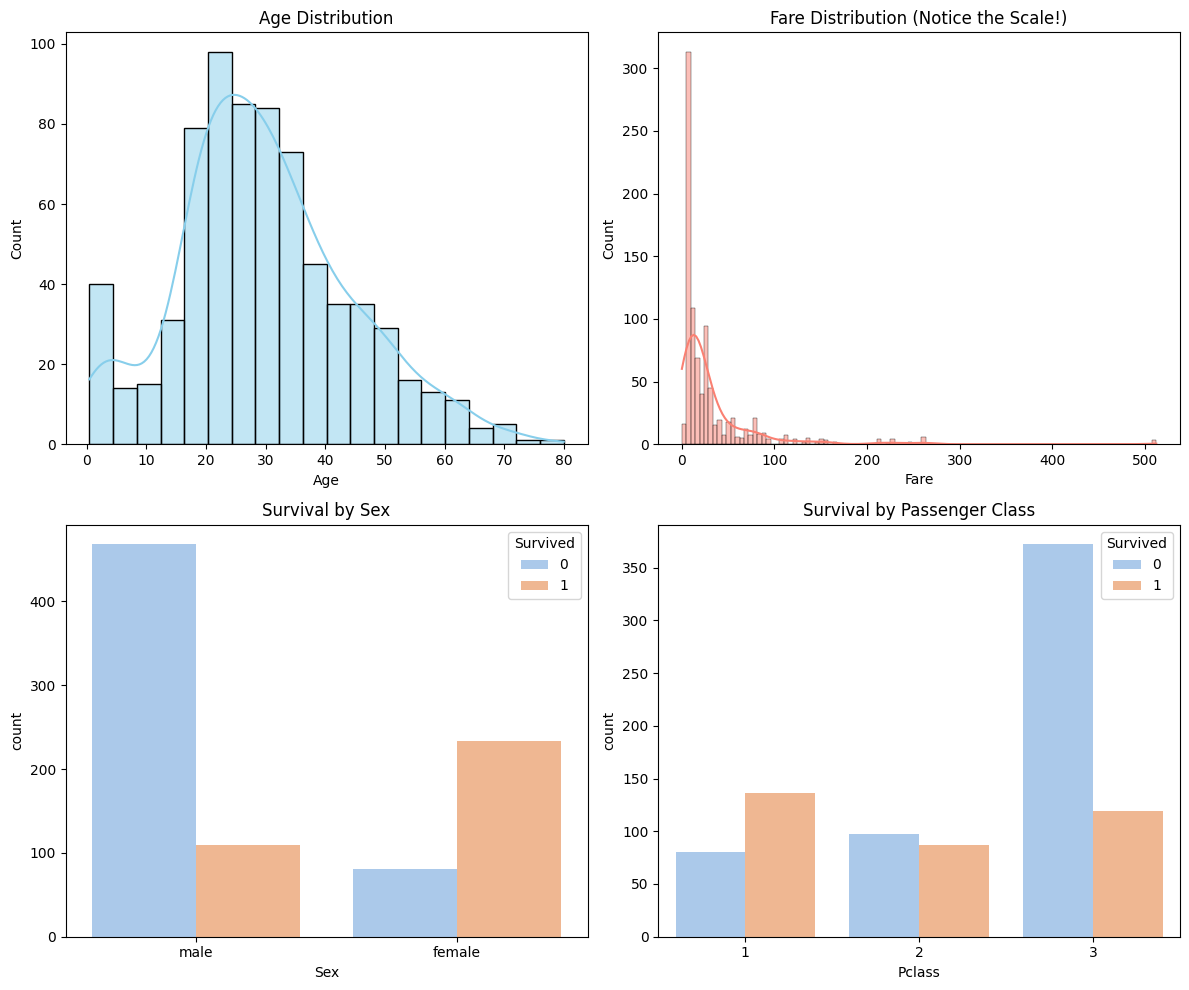

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Age Distribution
sns.histplot(df_raw['Age'].dropna(), kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Age Distribution')

# Fare Distribution (shows the scaling problem)
sns.histplot(df_raw['Fare'], kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Fare Distribution (Notice the Scale!)')

# Survival by Sex
sns.countplot(data=df_raw, x='Sex', hue='Survived', ax=axes[1, 0], palette='pastel')
axes[1, 0].set_title('Survival by Sex')

# Survival by Class
sns.countplot(data=df_raw, x='Pclass', hue='Survived', ax=axes[1, 1], palette='pastel')
axes[1, 1].set_title('Survival by Passenger Class')

plt.tight_layout()
plt.show()

**Observations**:
-   **Age** is roughly normally distributed, centered around 25-30.
-   **Fare** is heavily right-skewed. This confirms the need for scaling.
-   **Sex**: Females survived at a much higher rate than males.
-   **Class**: 1st class passengers survived more often than 3rd class.

## 3. Missing Data Diagnosis: MCAR, MAR, or MNAR?

Not all missing data is the same. The **reason** data is missing determines which imputation strategy we should use.


### 3.1 The Three Types of Missing Data

| Type | Full Name | Definition | Real-World Example | How to Fix |
| :--- | :--- | :--- | :--- | :--- |
| **MCAR** | Missing Completely At Random | The missingness has **NO relationship** to any variable (observed or unobserved). It's purely random. | A lab technician accidentally drops some blood samples. The dropped samples have nothing to do with the patient's health. | **Any method works**: Simple Imputer (mean/median), KNN, or MICE. The data is unbiased. |
| **MAR** | Missing At Random | The missingness is related to **other observed variables**, but not to the missing value itself. | Older patients skip a fitness test more often. Age (observed) predicts missingness, but fitness score (missing) does not. | **Use KNN or MICE**: These methods use the observed variables (like Age) to predict the missing value. Simple Imputer ignores these relationships. |
| **MNAR** | Missing Not At Random | The missingness is related to **the missing value itself**. | People with high incomes refuse to report their salary. The value of salary (missing) directly causes it to be missing. | **MICE is best** (but still imperfect). You may also need **domain knowledge** or **sensitivity analysis**. Simple/KNN will be biased. |


**Important**: We can *never* truly prove MNAR from the data alone, because the missing values are... missing! When in doubt, assume **MAR** and use **MICE** or 

### 3.3 Diagnosing the Titanic Data

Let's apply this framework to our two missing columns: **Age** and **Cabin**.

#### Test 1: Is Age Missing Correlated with Other Features?
We create a binary column `Age_Missing` (1 = missing, 0 = present) and check if it's correlated with `Pclass`, `Fare`, `Survived`, etc.

In [33]:
df_raw['Age_Missing'] = df_raw['Age'].isnull().astype(int)
print("Correlation of Age_Missing with other features:")
numeric_cols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Survived']
for col in numeric_cols:
    corr, pvalue = stats.pointbiserialr(df_raw['Age_Missing'], df_raw[col])
    significance = 'Significant' if pvalue < 0.05 else 'Not Significant'
    print(f"  {col:12s}: r = {corr:+.3f}, p = {pvalue:.4f} ({significance})")

Correlation of Age_Missing with other features:
  Pclass      : r = +0.173, p = 0.0000 (Significant)
  SibSp       : r = +0.019, p = 0.5720 (Not Significant)
  Parch       : r = -0.124, p = 0.0002 (Significant)
  Fare        : r = -0.101, p = 0.0026 (Significant)
  Survived    : r = -0.092, p = 0.0059 (Significant)


**Interpretation**:
-   If `Pclass` has a **significant** correlation with `Age_Missing`, it means 3rd class passengers are more likely to have missing Age. This suggests **MAR** (missingness depends on Class, not on Age itself).
-   If no column is correlated with `Age_Missing`, it could be **MCAR**.

#### Test 2: Visualize the Pattern
Let's see if the *distribution* of other features differs between passengers with known vs. missing Age.

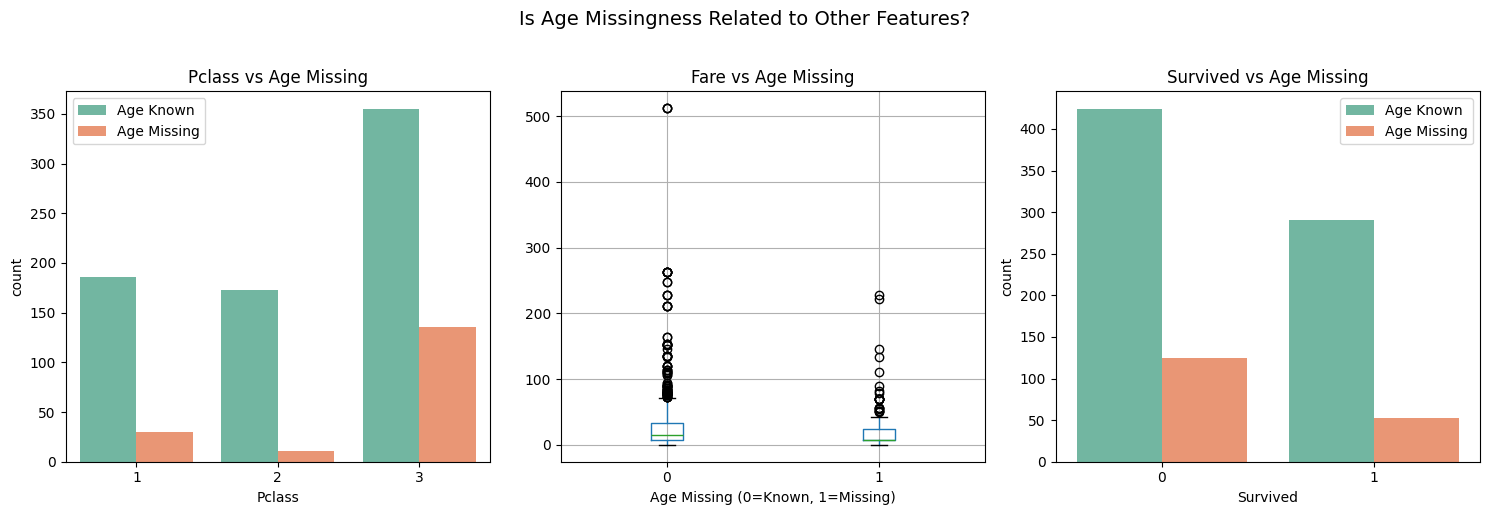

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data=df_raw, x='Pclass', hue='Age_Missing', ax=axes[0], palette='Set2')
axes[0].set_title('Pclass vs Age Missing')
axes[0].legend(['Age Known', 'Age Missing'])


df_raw.boxplot(column='Fare', by='Age_Missing', ax=axes[1])
axes[1].set_title('Fare vs Age Missing')
axes[1].set_xlabel('Age Missing (0=Known, 1=Missing)')

sns.countplot(data=df_raw, x='Survived', hue='Age_Missing', ax=axes[2], palette='Set2')
axes[2].set_title('Survived vs Age Missing')
axes[2].legend(['Age Known', 'Age Missing'])

plt.suptitle('Is Age Missingness Related to Other Features?', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

#### Test 3: Statistical Comparison (t-test)
We run a **t-test** to check if the mean Fare differs significantly between passengers with known vs. missing Age.

If the means are significantly different, the missingness is **NOT random** (i.e., not MCAR).

In [35]:
fare_known = df_raw[df_raw['Age_Missing'] == 0]['Fare']
fare_missing = df_raw[df_raw['Age_Missing'] == 1]['Fare']

t_stat, p_val = stats.ttest_ind(fare_known, fare_missing)
print(f"T-Test: Fare (Age Known vs Age Missing)")
print(f"  Mean Fare (Age Known):   {fare_known.mean():.2f}")
print(f"  Mean Fare (Age Missing): {fare_missing.mean():.2f}")
print(f"  T-statistic: {t_stat:.3f}")
print(f"  P-value:     {p_val:.4f}")
print()
if p_val < 0.05:
    print("Result: SIGNIFICANT difference. Age is NOT MCAR.")
    print("Diagnosis: Age missingness is likely MAR (related to Fare/Class).")
else:
    print("Result: No significant difference. Age COULD be MCAR.")

T-Test: Fare (Age Known vs Age Missing)
  Mean Fare (Age Known):   34.69
  Mean Fare (Age Missing): 22.16
  T-statistic: 3.018
  P-value:     0.0026

Result: SIGNIFICANT difference. Age is NOT MCAR.
Diagnosis: Age missingness is likely MAR (related to Fare/Class).


#### Diagnosing Cabin
**Cabin** is 77% missing. Let's check if it's related to class.

In [36]:
df_raw['Cabin_Missing'] = df_raw['Cabin'].isnull().astype(int)

print("Cabin Missingness by Passenger Class:")
print("="*50)
cabin_by_class = df_raw.groupby('Pclass')['Cabin_Missing'].mean() * 100
for pclass, pct in cabin_by_class.items():
    print(f"  Class {pclass}: {pct:.1f}% missing")

print()
chi2, p_val_cabin, _, _ = stats.chi2_contingency(
    pd.crosstab(df_raw['Pclass'], df_raw['Cabin_Missing'])
)
print(f"Chi-Square Test: p-value = {p_val_cabin:.6f}")
if p_val_cabin < 0.05:
    print("Result: Cabin missingness is STRONGLY related to Pclass.")
    print("Diagnosis: Cabin is MAR (3rd class passengers simply didn't have cabins recorded).")
    print("Could also be MNAR (cheaper tickets = no cabin assignment at all).")

Cabin Missingness by Passenger Class:
  Class 1: 18.5% missing
  Class 2: 91.3% missing
  Class 3: 97.6% missing

Chi-Square Test: p-value = 0.000000
Result: Cabin missingness is STRONGLY related to Pclass.
Diagnosis: Cabin is MAR (3rd class passengers simply didn't have cabins recorded).
Could also be MNAR (cheaper tickets = no cabin assignment at all).


### 3.4 Summary: Our Diagnosis

| Column | Missing % | Diagnosis | Reasoning | Best Imputer |
| :--- | :--- | :--- | :--- | :--- |
| **Age** | ~20% | **MAR** | Missingness correlates with Pclass and Fare. 3rd class passengers are more likely to have missing Age. | **KNN or MICE** (they use Pclass/Fare to predict Age) |
| **Cabin** | ~77% | **MAR / MNAR** | 3rd class has ~70% missing vs 1st class ~20%. Could be MAR (depends on class) or MNAR (no cabin = no record). | **Drop it** (too much missing) or **MICE** (if you want to try) |
| **Embarked** | ~0.2% | **MCAR** | Only 2 values missing out of 891. No pattern detected. | **Simple Imputer** (mode) is perfectly fine |

### 3.5 The Decision Guide

| Imputer | Best For | Why |
| :--- | :--- | :--- |
| **Simple (Mean/Median/Mode)** | **MCAR** data, or when speed is needed | Ignores relationships. Only safe when missingness is truly random. |
| **KNN Imputer** | **MAR** data | Uses neighboring rows to predict the missing value. Captures local patterns. |
| **MICE (Iterative Imputer)** | **MAR and MNAR** data | Builds a regression model per feature. Most robust. Handles complex dependencies. |

## 4. Imputation Inspection
Now that we know Age is **MAR**, let's see how each imputer handles it.

**Prediction**: Simple Imputer will be the worst (it ignores the MAR relationship), while KNN and MICE should produce more realistic values.

In [37]:
df_inspect = df_raw.copy()

df_inspect['Title'] = df_inspect['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
popular_titles = ['Mr', 'Miss', 'Mrs', 'Master']
df_inspect['Title'] = df_inspect['Title'].apply(lambda x: x if x in popular_titles else 'Other')

df_inspect['Deck'] = df_inspect['Cabin'].str[0]
deck_mapping = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8}
reverse_deck_mapping = {v: k for k, v in deck_mapping.items()}
df_inspect['Deck_Num'] = df_inspect['Deck'].map(deck_mapping)

df_inspect['Sex'] = df_inspect['Sex'].map({'male': 0, 'female': 1})
df_inspect['Embarked'] = df_inspect['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

cols_for_impute = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck_Num']
data_to_impute = df_inspect[cols_for_impute]

missing_age_idx = df_inspect[df_inspect['Age'].isnull()].index[:5]
missing_cabin_idx = df_inspect[df_inspect['Cabin'].isnull()].index[:5]
sample_idx = sorted(set(list(missing_age_idx) + list(missing_cabin_idx)))

### Running the Three Imputers

In [38]:
simp_imp = SimpleImputer(strategy='median')
df_simple_res = pd.DataFrame(simp_imp.fit_transform(data_to_impute), columns=cols_for_impute)

knn_imp = KNNImputer(n_neighbors=5)
df_knn_res = pd.DataFrame(knn_imp.fit_transform(data_to_impute), columns=cols_for_impute)

mice_imp = IterativeImputer(max_iter=10, random_state=0)
df_mice_res = pd.DataFrame(mice_imp.fit_transform(data_to_impute), columns=cols_for_impute)

### Side-by-Side Comparison
**What to notice**:
-   **Simple** fills *every* missing Age with the same number (the median = 28).
-   **KNN** and **MICE** calculate unique values per passenger, using Pclass, Fare, etc.

In [39]:
def num_to_deck(n):
    if pd.isna(n): return np.nan
    return reverse_deck_mapping.get(round(n), '?')

comparison = pd.DataFrame(index=sample_idx)
comparison['Original_Age'] = df_raw.loc[sample_idx, 'Age']
comparison['Simple_Age'] = df_simple_res.loc[sample_idx, 'Age']
comparison['KNN_Age'] = df_knn_res.loc[sample_idx, 'Age'].round(1)
comparison['MICE_Age'] = df_mice_res.loc[sample_idx, 'Age'].round(1)
comparison['Original_Deck'] = df_raw.loc[sample_idx, 'Cabin'].str[0]
comparison['Simple_Deck'] = df_simple_res.loc[sample_idx, 'Deck_Num'].apply(num_to_deck)
comparison['KNN_Deck'] = df_knn_res.loc[sample_idx, 'Deck_Num'].apply(num_to_deck)
comparison['MICE_Deck'] = df_mice_res.loc[sample_idx, 'Deck_Num'].apply(num_to_deck)

comparison

,Original_Age,Simple_Age,KNN_Age,MICE_Age,Original_Deck,Simple_Deck,KNN_Deck,MICE_Deck
0,22.0,22.0,22.0,22.0,NaN,C,F,F
2,26.0,26.0,26.0,26.0,NaN,C,F,F
4,35.0,35.0,35.0,35.0,NaN,C,E,F
5,NaN,28.0,40.6,28.0,NaN,C,F,E
7,2.0,2.0,2.0,2.0,NaN,C,E,G
17,NaN,28.0,27.8,35.0,NaN,C,E,E
19,NaN,28.0,23.0,25.4,NaN,C,F,F
26,NaN,28.0,32.5,28.2,NaN,C,F,F
28,NaN,28.0,21.7,25.2,NaN,C,F,F


## 5. Experiment Setup
We prepare the base dataset that all experiments will share:
1.  **Feature Engineer**: Extract 'Title' from Name.
2.  **Encode**: Convert text to numbers.
3.  **Drop**: Remove Cabin (77% missing), Name, Ticket, PassengerId.

In [40]:
df_exp = df_raw.copy()

df_exp['Title'] = df_exp['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df_exp['Title'] = df_exp['Title'].apply(lambda x: x if x in popular_titles else 'Other')

df_exp = df_exp.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId', 'Age_Missing', 'Cabin_Missing'])

df_exp['Sex'] = df_exp['Sex'].map({'male': 0, 'female': 1})
df_exp['Embarked'].fillna(df_exp['Embarked'].mode()[0], inplace=True)
df_exp = pd.get_dummies(df_exp, columns=['Embarked', 'Title'], drop_first=True)

X_raw = df_exp.drop('Survived', axis=1)
y = df_exp['Survived']

print(f"Features: {X_raw.shape[1]} columns")
X_raw.head()

Features: 12 columns


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,3,0,22.0,1,0,7.2500,False,True,False,True,False,False
1,1,1,38.0,1,0,71.2833,False,False,False,False,True,False
2,3,1,26.0,0,0,7.9250,False,True,True,False,False,False
3,1,1,35.0,1,0,53.1000,False,True,False,False,True,False
4,3,0,35.0,0,0,8.0500,False,True,False,True,False,False


### Helper Function
Trains both LogReg & KNN, prints full classification reports, stores results for the final leaderboard.

In [41]:
all_results = []

def run_experiment(X, y, imputer_name, scaled):
    """Train LogReg & KNN, print reports, store results."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scale_label = 'Scaled' if scaled else 'Unscaled'
    
    lr = LogisticRegression(max_iter=5)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    print(f"--- {imputer_name} | {scale_label} | Logistic Regression ---")
    print(f"Accuracy: {acc_lr:.4f}")
    print(classification_report(y_test, y_pred_lr))
    
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(X_train, y_train)
    y_pred_knn = knn_clf.predict(X_test)
    acc_knn = accuracy_score(y_test, y_pred_knn)
    print(f"--- {imputer_name} | {scale_label} | KNN Classifier ---")
    print(f"Accuracy: {acc_knn:.4f}")
    print(classification_report(y_test, y_pred_knn))
    
    all_results.append({'Imputer': imputer_name, 'Scaled': scale_label, 'Model': 'LogReg', 'Accuracy': round(acc_lr, 4)})
    all_results.append({'Imputer': imputer_name, 'Scaled': scale_label, 'Model': 'KNN', 'Accuracy': round(acc_knn, 4)})
    return y_test, y_pred_lr, y_pred_knn

## 6. Experiment 1: Simple Imputer (Median)
Replaces every missing Age with the **median** value (same number for everyone).

**Pros**: Fast, easy to understand.
**Cons**: Ignores the MAR relationship. Every missing value gets the *same* number.
**Best for**: MCAR data.

### 6.1 Impute & Train (Without Scaling)

In [42]:
simple_imp = SimpleImputer(strategy='median')
X_simple = pd.DataFrame(simple_imp.fit_transform(X_raw), columns=X_raw.columns)

_ = run_experiment(X_simple, y, 'Simple', scaled=False)

--- Simple | Unscaled | Logistic Regression ---
Accuracy: 0.6592
              precision    recall  f1-score   support

           0       0.64      0.93      0.76       105
           1       0.74      0.27      0.40        74

    accuracy                           0.66       179
   macro avg       0.69      0.60      0.58       179
weighted avg       0.68      0.66      0.61       179

--- Simple | Unscaled | KNN Classifier ---
Accuracy: 0.7151
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       105
           1       0.72      0.51      0.60        74

    accuracy                           0.72       179
   macro avg       0.72      0.69      0.69       179
weighted avg       0.72      0.72      0.70       179



### 6.2 Apply Scaling, Then Re-train
`StandardScaler` transforms each feature to have **mean=0** and **std=1**.

In [43]:
scaler = StandardScaler()
X_simple_scaled = pd.DataFrame(scaler.fit_transform(X_simple), columns=X_simple.columns)

_ = run_experiment(X_simple_scaled, y, 'Simple', scaled=True)

--- Simple | Scaled | Logistic Regression ---
Accuracy: 0.7989
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       105
           1       0.76      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

--- Simple | Scaled | KNN Classifier ---
Accuracy: 0.8101
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       105
           1       0.77      0.77      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



## 7. Experiment 2: KNN Imputer (Neighbors)
For each missing Age, finds the 5 most similar passengers and averages their ages.

**Pros**: Context-aware; uses the MAR relationship.
**Cons**: Sensitive to feature scales. Slower than Simple.
**Best for**: MAR data.

### 7.1 Impute & Train (Without Scaling)

In [44]:
knn_imp = KNNImputer(n_neighbors=5)
X_knn_imp = pd.DataFrame(knn_imp.fit_transform(X_raw), columns=X_raw.columns)

_ = run_experiment(X_knn_imp, y, 'KNN', scaled=False)

--- KNN | Unscaled | Logistic Regression ---
Accuracy: 0.6648
              precision    recall  f1-score   support

           0       0.65      0.93      0.77       105
           1       0.75      0.28      0.41        74

    accuracy                           0.66       179
   macro avg       0.70      0.61      0.59       179
weighted avg       0.69      0.66      0.62       179

--- KNN | Unscaled | KNN Classifier ---
Accuracy: 0.7151
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       105
           1       0.71      0.53      0.60        74

    accuracy                           0.72       179
   macro avg       0.71      0.69      0.69       179
weighted avg       0.71      0.72      0.71       179



### 7.2 Apply Scaling, Then Re-train
**Prediction**: KNN should improve significantly with scaling.

In [45]:
X_knn_scaled = pd.DataFrame(scaler.fit_transform(X_knn_imp), columns=X_knn_imp.columns)

_ = run_experiment(X_knn_scaled, y, 'KNN', scaled=True)

--- KNN | Scaled | Logistic Regression ---
Accuracy: 0.8101
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       105
           1       0.77      0.77      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

--- KNN | Scaled | KNN Classifier ---
Accuracy: 0.8101
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



## 8. Experiment 3: MICE Imputer (Iterative/Advanced)
Builds a **regression model** to predict each missing value from all other features.

**Pros**: Most statistically rigorous. Captures complex relationships.
**Cons**: Slowest. Can be sensitive to outliers.
**Best for**: MAR and MNAR data.

### 8.1 Impute & Train (Without Scaling)

In [46]:
mice_imp = IterativeImputer(max_iter=10, random_state=0)
X_mice = pd.DataFrame(mice_imp.fit_transform(X_raw), columns=X_raw.columns)

_ = run_experiment(X_mice, y, 'MICE', scaled=False)

--- MICE | Unscaled | Logistic Regression ---
Accuracy: 0.6704
              precision    recall  f1-score   support

           0       0.65      0.94      0.77       105
           1       0.78      0.28      0.42        74

    accuracy                           0.67       179
   macro avg       0.71      0.61      0.59       179
weighted avg       0.70      0.67      0.62       179

--- MICE | Unscaled | KNN Classifier ---
Accuracy: 0.7318
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       105
           1       0.73      0.55      0.63        74

    accuracy                           0.73       179
   macro avg       0.73      0.71      0.71       179
weighted avg       0.73      0.73      0.72       179



### 8.2 Apply Scaling, Then Re-train

In [47]:
X_mice_scaled = pd.DataFrame(scaler.fit_transform(X_mice), columns=X_mice.columns)

y_test_final, y_pred_lr_final, y_pred_knn_final = run_experiment(X_mice_scaled, y, 'MICE', scaled=True)

--- MICE | Scaled | Logistic Regression ---
Accuracy: 0.8156
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       105
           1       0.77      0.78      0.78        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

--- MICE | Scaled | KNN Classifier ---
Accuracy: 0.8212
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       105
           1       0.78      0.80      0.79        74

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



## 9. Final Results: The Leaderboard

In [48]:
df_results = pd.DataFrame(all_results)
df_results = df_results.sort_values('Accuracy', ascending=False).reset_index(drop=True)
df_results.index = df_results.index + 1
df_results.index.name = 'Rank'
df_results

,Imputer,Scaled,Model,Accuracy
Rank,,,,
1,MICE,Scaled,KNN,0.8212
2,MICE,Scaled,LogReg,0.8156
3,Simple,Scaled,KNN,0.8101
4,KNN,Scaled,LogReg,0.8101
5,KNN,Scaled,KNN,0.8101
6,Simple,Scaled,LogReg,0.7989
7,MICE,Unscaled,KNN,0.7318
8,Simple,Unscaled,KNN,0.7151
9,KNN,Unscaled,KNN,0.7151


### Visual Comparison

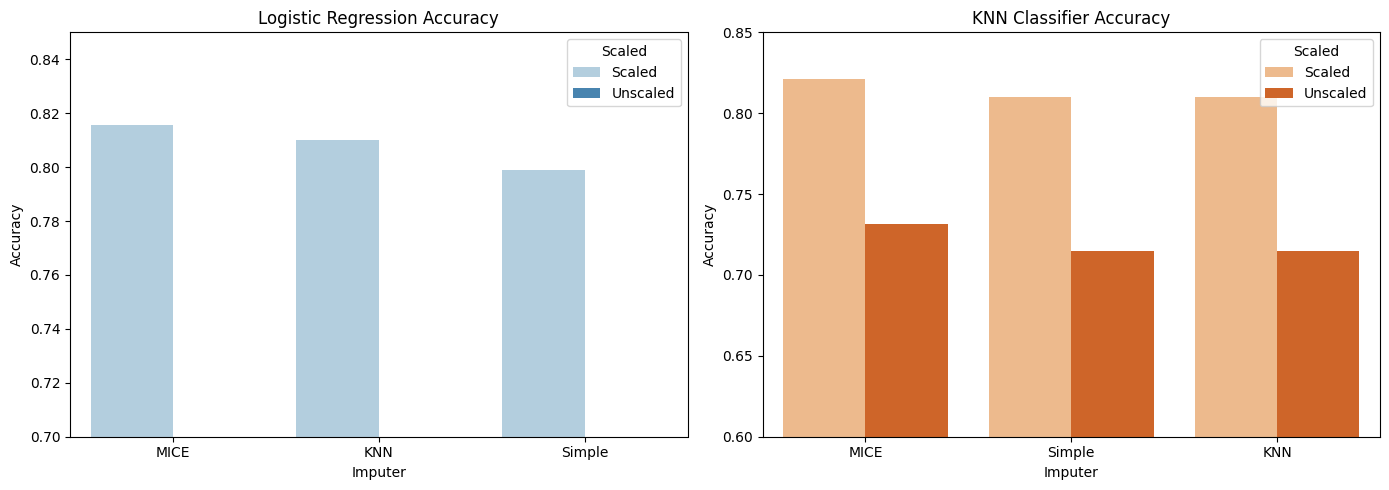

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

lr_results = df_results[df_results['Model'] == 'LogReg']
sns.barplot(data=lr_results, x='Imputer', y='Accuracy', hue='Scaled', ax=axes[0], palette='Blues')
axes[0].set_title('Logistic Regression Accuracy')
axes[0].set_ylim(0.7, 0.85)

knn_results = df_results[df_results['Model'] == 'KNN']
sns.barplot(data=knn_results, x='Imputer', y='Accuracy', hue='Scaled', ax=axes[1], palette='Oranges')
axes[1].set_title('KNN Classifier Accuracy')
axes[1].set_ylim(0.6, 0.85)

plt.tight_layout()
plt.show()

## 10. Confusion Matrix (Best Model)
-   **True Positive (TP)**: Predicted Survived, actually Survived.
-   **True Negative (TN)**: Predicted Died, actually Died.
-   **False Positive (FP)**: Predicted Survived, actually Died (Type I Error).
-   **False Negative (FN)**: Predicted Died, actually Survived (Type II Error).

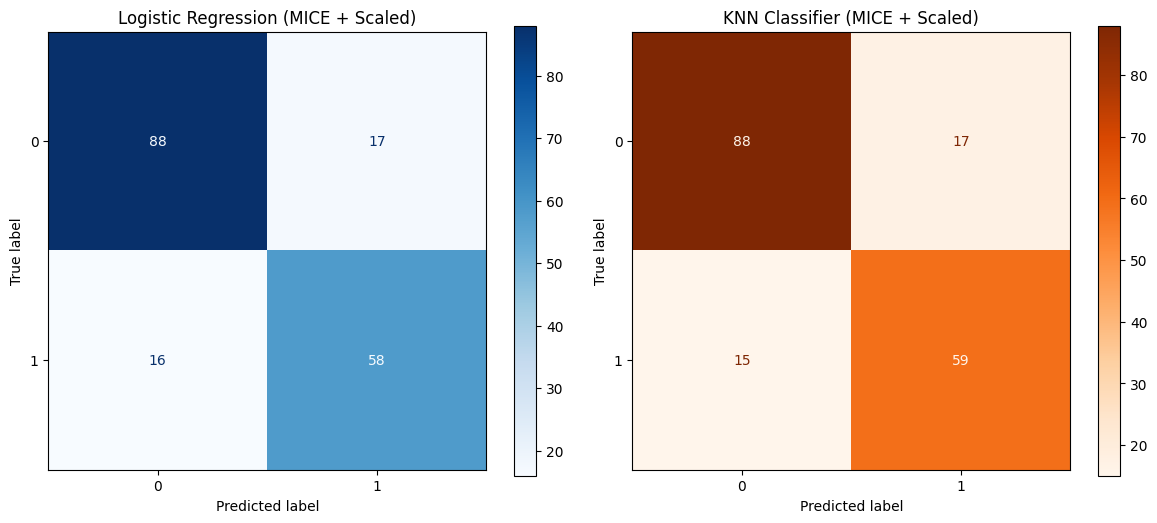

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred_lr_final, ax=axes[0], cmap='Blues')
axes[0].set_title('Logistic Regression (MICE + Scaled)')

ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred_knn_final, ax=axes[1], cmap='Oranges')
axes[1].set_title('KNN Classifier (MICE + Scaled)')

plt.tight_layout()
plt.show()

## 11. Key Takeaways

### Missing Data
1.  Always **diagnose** the type of missingness before choosing an imputer.
2.  **MCAR** (random): Any imputer works. Simple is fine.
3.  **MAR** (depends on other columns): Use KNN or MICE. They leverage the relationship.
4.  **MNAR** (depends on the missing value itself): MICE is your best bet, but also consider domain knowledge.

### Modeling
5.  **Scaling** consistently helps distance-based models (KNN) and regularized models (Logistic Regression).
6.  **Accuracy alone is not enough**. Classification Report reveals Precision vs Recall trade-offs.
7.  The **best pipeline** is typically: MICE + Scaling + a well-tuned classifier.

## Discussion Questions

1.  Why does **KNN Classifier** improve so dramatically after scaling, while **Logistic Regression** may not change as much?
2.  We diagnosed Age as **MAR**. What would change if it were **MCAR** instead? Would the imputer choice matter less?
3.  In what real-world scenario would you prefer **high Recall** over **high Precision**? (Hint: think about medical tests.)
4.  We dropped **Cabin** because 77% was missing. Could we have kept it? What are the risks?
5.  If you suspect a column is **MNAR**, what strategies beyond imputation could you use? (Hint: think about creating a binary "is_missing" feature.)